<img src="http://drive.google.com/uc?export=view&id=1tpOCamr9aWz817atPnyXus8w5gJ3mIts" width=500px>

Proprietary content. © Great Learning. All Rights Reserved. Unauthorized use or distribution prohibited.

# Sarcasm Detection

- By Sandesh Balyan

### Dataset

#### Acknowledgement
Misra, Rishabh, and Prahal Arora. "Sarcasm Detection using Hybrid Neural Network." arXiv preprint arXiv:1908.07414 (2019).

In [ ]:
%tensorflow_version 2.x
import tensorflow
tensorflow.__version__

'2.3.0'

In [ ]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report,accuracy_score, confusion_matrix

from tensorflow import keras
from keras.models import Model, Sequential
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.layers import Dense, Dropout, Embedding, Flatten, Bidirectional, LSTM, GlobalMaxPool1D
from keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
from keras.initializers import Constant

import nltk
nltk.download('wordnet')

from zipfile import ZipFile

random_state = 42


[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [ ]:
# mounting google drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# changing working directory
import os
os.chdir('/content/drive/MyDrive/Colab Notebooks/05-NLP-SarcasmDetection')

#verifying current working directory
!pwd

/content/drive/MyDrive/Colab Notebooks/05-NLP-SarcasmDetection


### 1. Load Data

In [ ]:
data = pd.read_json('Sarcasm_Headlines_Dataset.json', lines=True)
data.head()

,article_link,headline,is_sarcastic
0,https://www.huffingtonpost.com/entry/versace-b...,former versace store clerk sues over secret 'b...,0
1,https://www.huffingtonpost.com/entry/roseanne-...,the 'roseanne' revival catches up to our thorn...,0
2,https://local.theonion.com/mom-starting-to-fea...,mom starting to fear son's web series closest ...,1
3,https://politics.theonion.com/boehner-just-wan...,"boehner just wants wife to listen, not come up...",1
4,https://www.huffingtonpost.com/entry/jk-rowlin...,j.k. rowling wishes snape happy birthday in th...,0


##### 1.1 Dataset Shape

In [ ]:
data.shape

(26709, 3)

There are total 26709 headlines and 3 columns in the dataset

Column headline contains the actual sentences and is_sarcastic contains weather the headline is sarcastic(1) or not(0)

##### 1.2 Exploring dataset

In [ ]:
# checking duplicates
print('Count of duplicate records in the dataset are {0}'.format(data.duplicated().sum()))

Count of duplicate records in the dataset are 1


In [ ]:
# dropping dulicates and verifying the shape again
data = data.drop_duplicates()
print('New Shape of the dataset {}'.format(data.shape))

New Shape of the dataset (26708, 3)


In [ ]:
# checking missing values if any in any of the columns
data.isna().sum()

article_link    0
headline        0
is_sarcastic    0
dtype: int64

There are no null values in any of the columns

In [ ]:
# Checking the percentage of is_sarcastic true and false
data.groupby(by=['is_sarcastic']).count()

,article_link,headline
is_sarcastic,,
0,14984,14984
1,11724,11724


In [ ]:
print('% of headlines which are NOT sarcastic  :{0:.2f}%'.format(data.groupby(by=['is_sarcastic']).count()['headline'][0]/data.shape[0]*100))
print('% of headlines which are sarcastic      :{0:.2f}%'.format(data.groupby(by=['is_sarcastic']).count()['headline'][1]/data.shape[0]*100))

% of headlines which are NOT sarcastic  :56.10%
% of headlines which are sarcastic      :43.90%


### Drop `article_link` from dataset

In [ ]:
data = data.drop(['article_link'],axis=1)
data.head()

,headline,is_sarcastic
0,former versace store clerk sues over secret 'b...,0
1,the 'roseanne' revival catches up to our thorn...,0
2,mom starting to fear son's web series closest ...,1
3,"boehner just wants wife to listen, not come up...",1
4,j.k. rowling wishes snape happy birthday in th...,0


### Text preprocessing
In this section we will take care of the various issues with data viz:

1. Cleaning
2. removal of special characters and punctuations
3. handling lower and upper cases etc.

In [ ]:
# Converting text in headline to lower case
data['new_headline'] = data['headline'].str.lower()
data.head()

,headline,is_sarcastic,new_headline
0,former versace store clerk sues over secret 'b...,0,former versace store clerk sues over secret 'b...
1,the 'roseanne' revival catches up to our thorn...,0,the 'roseanne' revival catches up to our thorn...
2,mom starting to fear son's web series closest ...,1,mom starting to fear son's web series closest ...
3,"boehner just wants wife to listen, not come up...",1,"boehner just wants wife to listen, not come up..."
4,j.k. rowling wishes snape happy birthday in th...,0,j.k. rowling wishes snape happy birthday in th...


In [ ]:
#removing special characters including punctuation marks fron column new_headline
def remove_special_characters(text):
  specialCharacters = '''!()-[]{};:'"\,<>./?@#$%^&*_~'''
  newString = ''
  for char in text:
    if char not in specialCharacters:
      newString = newString + char
  return newString

data['new_headline'] = data['new_headline'].apply(remove_special_characters)

data.head()


,headline,is_sarcastic,new_headline
0,former versace store clerk sues over secret 'b...,0,former versace store clerk sues over secret bl...
1,the 'roseanne' revival catches up to our thorn...,0,the roseanne revival catches up to our thorny ...
2,mom starting to fear son's web series closest ...,1,mom starting to fear sons web series closest t...
3,"boehner just wants wife to listen, not come up...",1,boehner just wants wife to listen not come up ...
4,j.k. rowling wishes snape happy birthday in th...,0,jk rowling wishes snape happy birthday in the ...


In [ ]:
#Lemmatization : finding the root words of words in each sentence
word_tokeniser = nltk.tokenize.WhitespaceTokenizer()
word_lemmatiser = nltk.stem.WordNetLemmatizer()



#defining a function for lemmatisation
def text_lemmatizer(sentences):
  lst = [word_lemmatiser.lemmatize(w) for w in word_tokeniser.tokenize(sentences)]
  sent = ''
  for i in range(len(lst)):
    sent = sent + ' ' + lst[i]
  return sent


data['new_headline'] =  data['new_headline'].apply(lambda x: text_lemmatizer(x))
data.head()


,headline,is_sarcastic,new_headline
0,former versace store clerk sues over secret 'b...,0,former versace store clerk sue over secret bl...
1,the 'roseanne' revival catches up to our thorn...,0,the roseanne revival catch up to our thorny p...
2,mom starting to fear son's web series closest ...,1,mom starting to fear son web series closest t...
3,"boehner just wants wife to listen, not come up...",1,boehner just want wife to listen not come up ...
4,j.k. rowling wishes snape happy birthday in th...,0,jk rowling wish snape happy birthday in the m...


In above section we have lemmatized words in each sentence and then converted the tokens back to original sentence

Overall all the sentences have been converted to lower case, punctuations removed and lemmatized

Also, we can see some leading spaces in the begining of the sentences in the column new_headline. We shall trim all the spaces as the final preprocessing step.

In [ ]:
# removing leading spaces and double spaces from new_headline column
# we will keep individual spaces to maintain the sentence as it is

# to remove leading and trailing spaces
data['new_headline'] = data['new_headline'].str.strip()
data.head()

,headline,is_sarcastic,new_headline
0,former versace store clerk sues over secret 'b...,0,former versace store clerk sue over secret bla...
1,the 'roseanne' revival catches up to our thorn...,0,the roseanne revival catch up to our thorny po...
2,mom starting to fear son's web series closest ...,1,mom starting to fear son web series closest th...
3,"boehner just wants wife to listen, not come up...",1,boehner just want wife to listen not come up w...
4,j.k. rowling wishes snape happy birthday in th...,0,jk rowling wish snape happy birthday in the mo...


In [ ]:
## remove more than one spaces
data['new_headline'] = data['new_headline'].str.replace("  ","")
data.head()

,headline,is_sarcastic,new_headline
0,former versace store clerk sues over secret 'b...,0,former versace store clerk sue over secret bla...
1,the 'roseanne' revival catches up to our thorn...,0,the roseanne revival catch up to our thorny po...
2,mom starting to fear son's web series closest ...,1,mom starting to fear son web series closest th...
3,"boehner just wants wife to listen, not come up...",1,boehner just want wife to listen not come up w...
4,j.k. rowling wishes snape happy birthday in th...,0,jk rowling wish snape happy birthday in the mo...


### Get length of each headline and add a column for that

In [ ]:
lstLength = []
for idx,row in data.iterrows():
  lstLength.append(len(row[0]))

data['word_count'] = lstLength

In [ ]:
data.head()

,headline,is_sarcastic,new_headline,word_count
0,former versace store clerk sues over secret 'b...,0,former versace store clerk sue over secret bla...,78
1,the 'roseanne' revival catches up to our thorn...,0,the roseanne revival catch up to our thorny po...,84
2,mom starting to fear son's web series closest ...,1,mom starting to fear son web series closest th...,79
3,"boehner just wants wife to listen, not come up...",1,boehner just want wife to listen not come up w...,84
4,j.k. rowling wishes snape happy birthday in th...,0,jk rowling wish snape happy birthday in the mo...,64


In [ ]:
## Analysing dataset based on word count in each headline
print('Analysis of the complete dataset')
data['word_count'].describe()

Analysis of the complete dataset


count    26708.000000
mean        60.911862
std         19.183707
min          7.000000
25%         48.000000
50%         61.000000
75%         73.000000
max        254.000000
Name: word_count, dtype: float64

1. min number of words are 7 while max is 254
2. Mean = 60 and median count = 61 are close to each other. there doesnot seem to be any skewness in the length of the dataset

In [ ]:
data[data['is_sarcastic']==0]['word_count'].describe()

count    14984.000000
mean        59.560798
std         17.317411
min          7.000000
25%         48.000000
50%         61.000000
75%         71.000000
max        228.000000
Name: word_count, dtype: float64

In [ ]:
data[data['is_sarcastic']==1]['word_count'].describe()

count    11724.000000
mean        62.638605
std         21.208409
min          8.000000
25%         48.000000
50%         61.000000
75%         76.000000
max        254.000000
Name: word_count, dtype: float64

### Initialize parameter values
- Set values for max_features, maxlen, & embedding_size
- max_features: Number of words to take from tokenizer(most frequent words)
- maxlen: Maximum length of each sentence to be limited to 25
- embedding_size: size of embedding vector

In [ ]:
max_features = 10000
maxlen = 25
embedding_size = 200

### Apply `tensorflow.keras` Tokenizer and get indices for words
- Initialize Tokenizer object with number of words as 10000
- Fit the tokenizer object on headline column
- Convert the text to sequence


In [ ]:
tokenizer = Tokenizer(num_words = max_features)
tokenizer.fit_on_texts(list(data['new_headline']))

In [ ]:
data.head()

,headline,is_sarcastic,new_headline,word_count
0,former versace store clerk sues over secret 'b...,0,former versace store clerk sue over secret bla...,78
1,the 'roseanne' revival catches up to our thorn...,0,the roseanne revival catch up to our thorny po...,84
2,mom starting to fear son's web series closest ...,1,mom starting to fear son web series closest th...,79
3,"boehner just wants wife to listen, not come up...",1,boehner just want wife to listen not come up w...,84
4,j.k. rowling wishes snape happy birthday in th...,0,jk rowling wish snape happy birthday in the mo...,64


### Pad sequences 
- Pad each example with a maximum length
- Convert target column into numpy array

In [ ]:
headlines = tokenizer.texts_to_sequences(data['new_headline'])

In [ ]:
X = pad_sequences(headlines,maxlen=maxlen)

In [ ]:
#printing an example sequence
X[0]

array([   0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,  330,  694, 2947, 1268,   54,  293,  102, 1933,
          6, 2033, 3633], dtype=int32)

##### Preparing labels

In [ ]:
y = np.asarray(data['is_sarcastic'])
y[0]

0

##### Preparing train and test set

In [ ]:
X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.25,random_state=random_state)

In [ ]:
print('Size of training dataset       : {0}'.format(X_train.shape[0]))
print('Size of test dataset           : {0}'.format(X_test.shape[0]))
print('Size of training labels        : {0}'.format(y_train.shape[0]))
print('Size of test labels            : {0}'.format(y_test.shape[0]))


Size of training dataset       : 20031
Size of test dataset           : 6677
Size of training labels        : 20031
Size of test labels            : 6677


### Vocab mapping
- There is no word for 0th index

### Set number of words
- Since the above 0th index doesn't have a word, add 1 to the length of the vocabulary

In [ ]:
vocab = tokenizer.word_index
vocab_size = len(vocab) + 1 #no word ar zeroth index
print('Vocabulary size or number of unique words : {0}'.format(vocab_size))

Vocabulary size or number of unique words : 24981


### Load Glove Word Embeddings 

In [ ]:
glove_file = 'glove.6B.zip'

### Create embedding matrix

In [ ]:
#Extracting zip file
with ZipFile(glove_file,'r') as zp:
  zp.extractall()

In [ ]:
EMBEDDING_FILE = './glove.6B.200d.txt'

embeddings = {}
for o in open(EMBEDDING_FILE):
    word = o.split(" ")[0]
    # print(word)
    embd = o.split(" ")[1:]
    embd = np.asarray(embd, dtype='float32')
    # print(embd)
    embeddings[word] = embd

# create a weight matrix for words in training docs
embedding_matrix = np.zeros((vocab_size, 200))

for word, i in tokenizer.word_index.items():
	embedding_vector = embeddings.get(word)
	if embedding_vector is not None:
		embedding_matrix[i] = embedding_vector

In [ ]:
print(len(embeddings))

400000


### Define model
- Hint: Use Sequential model instance and then add Embedding layer, Bidirectional(LSTM) layer, flatten it, then dense and dropout layers as required. 
In the end add a final dense layer with sigmoid activation for binary classification.

In [ ]:
model = Sequential()
#adding embedding layer
model.add(Embedding(vocab_size,embedding_size,embeddings_initializer=Constant(embedding_matrix),input_length=maxlen,trainable=False))
#adding Bidirectional LSTM layer
model.add(Bidirectional(LSTM(128,return_sequences=True)))
model.add(GlobalMaxPool1D())
#Flatten Layer
model.add(Flatten())
model.add(Dropout(0.5))

#Dense and Dropout layers
model.add(Dense(128,activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(64,activation='relu'))
model.add(Dropout(0.5))

#final dense layer with Sigmoid layer
model.add(Dense(1,activation='sigmoid'))





In [ ]:
print(model.summary())

Model: "sequential_9"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_9 (Embedding)      (None, 25, 200)           4996200   
_________________________________________________________________
bidirectional_9 (Bidirection (None, 25, 256)           336896    
_________________________________________________________________
global_max_pooling1d_7 (Glob (None, 256)               0         
_________________________________________________________________
flatten_7 (Flatten)          (None, 256)               0         
_________________________________________________________________
dropout_25 (Dropout)         (None, 256)               0         
_________________________________________________________________
dense_27 (Dense)             (None, 128)               32896     
_________________________________________________________________
dropout_26 (Dropout)         (None, 128)              

### Compile the model

In [ ]:
# defining callbacks

earlyStopping = EarlyStopping(monitor='val_loss',mode='min',patience=5,verbose=1)
modelCheckpoint = ModelCheckpoint('sarcasm_model.h5',monitor='val_loss',verbose=1,save_best_only=True,mode='min')
reduceLR = ReduceLROnPlateau(monitor='val_loss',patience=5,factor=0.1)

callbacks = [earlyStopping,modelCheckpoint,reduceLR]

In [ ]:
#compiling the model
model.compile(optimizer='adam',loss='binary_crossentropy',metrics=['accuracy'])

### Fit the model

In [ ]:
batch_size=100
epochs=6
training = model.fit(X_train,y_train,batch_size=batch_size,epochs=epochs,verbose=1,callbacks=callbacks,validation_data=(X_test,y_test))

Epoch 1/6
196/201 [============================>.] - ETA: 0s - loss: 0.5905 - accuracy: 0.6754
Epoch 00001: val_loss improved from inf to 0.45169, saving model to sarcasm_model.h5
201/201 [==============================] - 7s 34ms/step - loss: 0.5887 - accuracy: 0.6771 - val_loss: 0.4517 - val_accuracy: 0.7918
Epoch 2/6
199/201 [============================>.] - ETA: 0s - loss: 0.4349 - accuracy: 0.8029
Epoch 00002: val_loss improved from 0.45169 to 0.38946, saving model to sarcasm_model.h5
201/201 [==============================] - 8s 39ms/step - loss: 0.4351 - accuracy: 0.8025 - val_loss: 0.3895 - val_accuracy: 0.8237
Epoch 3/6
198/201 [============================>.] - ETA: 0s - loss: 0.3666 - accuracy: 0.8428
Epoch 00003: val_loss improved from 0.38946 to 0.36764, saving model to sarcasm_model.h5
201/201 [==============================] - 7s 34ms/step - loss: 0.3666 - accuracy: 0.8426 - val_loss: 0.3676 - val_accuracy: 0.8388
Epoch 4/6
195/201 [============================>.] - ETA

#### Model evaluation

In [ ]:
def plot_graph(history,string):
    plt.figure(figsize=(8,4))
    plt.plot(history.history[string],label=str(string))
    plt.plot(history.history["val_"+str(string)],label=str(string))
    plt.xlabel("Epochs")
    plt.ylabel(string)
    plt.legend([string,"val_"+string])
    plt.show()

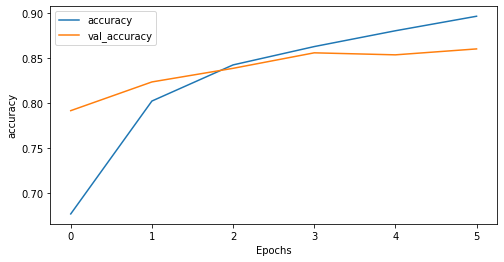

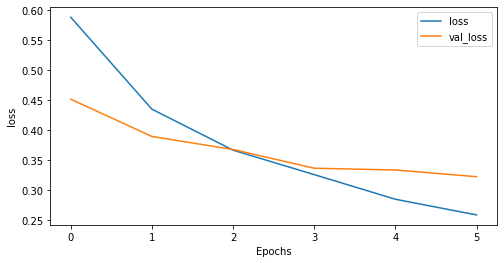

In [ ]:
plot_graph(training,"accuracy")
plot_graph(training,"loss")

We can observe that validation accuracy increases very slowly, while loss starts to increase with increase in number of epochs

In [ ]:
# model evaluation on test set
loss,accuracy = model.evaluate(X_test,y_test)
print('Total Accuracy on test set :{0:.2f} %'.format(accuracy*100))
print('Total Loss on test set :{0:.4f}'.format(loss))

209/209 [==============================] - 1s 4ms/step - loss: 0.3222 - accuracy: 0.8604
Total Accuracy on test set :86.04 %
Total Loss on test set :0.3222


In [ ]:
#classification report
y_pred = model.predict(X_test).round()

print('Classification Report : ')
print(classification_report(y_test,y_pred))


Classification Report : 
              precision    recall  f1-score   support

           0       0.87      0.88      0.88      3763
           1       0.85      0.83      0.84      2914

    accuracy                           0.86      6677
   macro avg       0.86      0.86      0.86      6677
weighted avg       0.86      0.86      0.86      6677



Overall precision, recall and F1 scores are same and as high as 85%

In [ ]:
#confusion matrix
cm = confusion_matrix(y_test,y_pred)
df_cm = pd.DataFrame(data=cm,columns=['non-sarcastic','sarcastic'],index=['non-sarcastic','sarcastic'])
df_cm

,non-sarcastic,sarcastic
non-sarcastic,3327,436
sarcastic,496,2418


# Conclusions



1.   Following preprocessing steps were used
      1. lower case conversion
      2. removing special chracters
      3. lemmatization


2.   Glove embeddings were used to create embeddings
3.   Bidirectional LSTM model was used
4.   Model achieves an acceptable accuracy of 86%   
5.   Different splits, batch size and epochs are tried, Best result received using  batch size=100 and epochs = 6








